# StreamingHistory0 Exploration

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import re

from datetime import datetime
from operator import itemgetter
from pprint import pprint
from itertools import combinations

In [2]:
with open("data/StreamingHistory0.json", mode="r", encoding="utf-8") as f:
    data = json.loads(f.read())

_df = pd.DataFrame(data)
_df.endTime = pd.to_datetime(_df.endTime)
skipped = _df[_df.msPlayed <= 10_000]
df = _df[_df.msPlayed > 10_000]
# df.endTime = df.endTime.apply(lambda dt: datetime.strptime(dt, "%Y-%m-%d %H:%M"))

In [3]:
# _df.groupby("trackName").apply(lambda df: (np.sum(df.msPlayed <= 10_000) / len(df), len(df))).sort_values(ascending=False).head(20)
# _df.sort_values(by="endTime", ascending=False).head(40)
_df[_df.endTime.dt.year == 2021].drop_duplicates().shape

(6539, 4)

Fleet Foxes      277
Fleetwood Mac    147
Name: artistName, dtype: int64
On the Floor    21
Honeybody       15
Name: trackName, dtype: int64


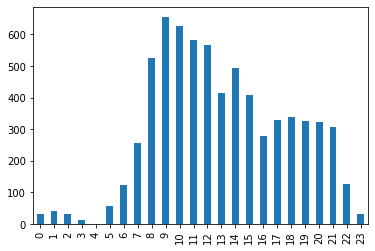

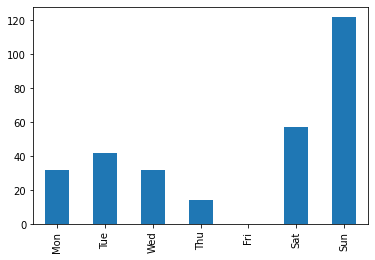

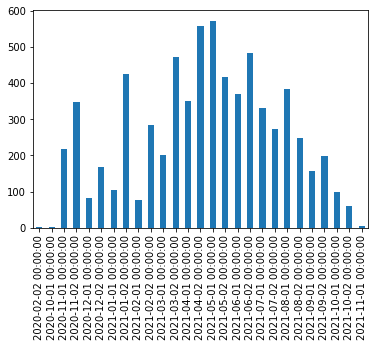

2020-01-07     1
2020-09-21     1
2020-09-29    17
2020-10-05    77
2020-10-06    51
              ..
2021-08-24    96
2021-09-20    70
2021-09-21    10
2021-09-27    33
2021-09-28    49
Name: endTime, Length: 97, dtype: int64

In [4]:
print(df.artistName.value_counts().head(2))
print(df.trackName.value_counts().head(2))
df[["artistName", "trackName"]].value_counts().head(5)

times = df.endTime.dt.hour.value_counts()
times = times.reindex(range(24), fill_value=0)
times.sort_index().plot(kind="bar")
plt.show()

weekdays = df.endTime.dt.dayofweek.value_counts()
weekdays = times.reindex(range(7), fill_value=0).sort_index()
weekdays.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
weekdays.plot(kind="bar")
plt.show()

months = df['endTime'] - pd.offsets.MonthBegin(0)
months = months.dt.round('d')
months = months.value_counts()
months = months.sort_index()
months.plot(kind="bar")
plt.show()

# Below is not correct
weeks = df['endTime'] - pd.to_timedelta(df['endTime'].dt.dayofweek, unit='d')
weeks = weeks.dt.round('d')
weeks = weeks.value_counts()
weeks = weeks.sort_index()
weeks


In [5]:
import requests

oauth_token = "Bearer BQAbeiv-i2bwyloeoj6gWNcNy2ca9XqvyuX5hi-GNrSJrEV4UFWK5M9z-ypghlM0_qPRwi6AfFhWMlDyIUnE_6oRnWpYefHNyBprpxqtURpvWvvyoUDp2vMJuQG7kF7nRNgCQ-F4Mkk27q9s_NRXyQhGF_1bPaYcRGU-uCjesV_Zp3U0Ill-40BSBjNirWQVUbGWvHV6FElCgNUEO98SCD9GlSmHblQ6xFS0rFAYr4KSgsMurWy3CCfMAbZ4T6YabqwAlRn_sxJfRPneMAI"
headers = {
    "Accept": "application/json",
    "Content-Type": "application/json",
    "Authorization": oauth_token
}

def get_track_data_by_name(artist_name, track_name):
    def normalize_str(s):
        return re.sub("\'`´", "", s.lower())
    
    def search(params):
        resp = requests.get(endpoint, headers=headers, params=params)
        data = json.loads(resp.text)
        tracks = data['tracks']['items']
        found_tracks.update(", ".join(a["name"] for a in track["artists"]) + " - " + track["name"]
                            for track in tracks)
        return next(track for track in tracks
                       if normalize_str(track['name']) == normalize_str(track_name)
                       and artist_name in [a["name"] for a in track["artists"]])
    
    found_tracks = set()
    endpoint = "https://api.spotify.com/v1/search"
    params = {"q": track_name + " " + artist_name, "type": "track", "limit": 20}
    try:
        try:
            return search(params)
        except StopIteration:
            return search(params | {"q": track_name})
    except json.JSONDecodeError as e:
        print(resp.text)
        raise e
    except KeyError as e:
        print("bad data:")
        pprint(data)
        raise e
    except StopIteration:        
        print(f"unable to find: {artist_name} - {track_name}")
        print("found:", found_tracks, end="\n\n")
    

def get_artist_data_by_name(artist_name):
    endpoint = "https://api.spotify.com/v1/search"
    params = {"q": artist_name, "type": "artist", "limit": 10}
    resp = requests.get(endpoint, headers=headers, params=params)
    data = json.loads(resp.text)
    artist_data = [artist for artist in data['artists']['items'] if artist['name'] == artist_name]
    ranked_by_popularity = sorted(artist_data, key=lambda a: a['followers']['total'], reverse=True)
    
    if artist_data:
        return ranked_by_popularity[0]
    
    print("unable to find", artist_name)

def get_related_artists(artist_id):
    endpoint = f"https://api.spotify.com/v1/artists/{artist_id}/related-artists"
    resp = requests.get(endpoint, headers=headers)
    
    if resp.status_code == 200:
        return json.loads(resp.text)['artists']
    
    print("Could not find", artist_id)
    
#get_artist_data_by_name("Muse")

In [6]:
from ast import literal_eval

def scrape_track_data():
    # Uniquely identify tracks by artist_name + track_name
    # Since these are stored as a tuple, and json doesn't support tuple keys, extra work has to be done when reading and writing.
    # Spotify has unique ids for all tracks, but our local data doesn't. TODO: Integrate track and artist id into streaming history
    try:
        with open('data/track_data.json', mode='r', encoding='utf-8') as f:
            data = json.load(f)
            data = {literal_eval(k): v for k, v in data.items()}
    except FileNotFoundError:
        data = {}
        
    known_tracks = pd.Series(data.keys())
    all_tracks = pd.Series(df[["artistName", "trackName"]].agg(tuple, axis=1).unique())
    unknown_tracks = all_tracks[~all_tracks.isin(known_tracks)]
    
    if False:  # retrieve missing entries from spotify API
        try:
            for artist, track in unknown_tracks:
                result = get_track_data_by_name(artist, track)
                if result:
                    data[(artist, track)] = result
        finally:
            with open('data/track_data.json', mode='w+', encoding='utf-8') as f:
                json.dump({str(k): v for k,v in data.items()}, f)

    return data

def scrape_artist_data():
    try:
        with open('data/artist_data.json', mode='r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        data = []
        
    known_artists = pd.Series([artist['name'] for artist in data if artist is not None])
    all_artists = pd.Series(df.artistName.unique())
    unknown_artists = all_artists[~all_artists.isin(known_artists)]
    
    if False:  # retrieve missing entries from spotify API
        try:
            for artist in unknown_artists:
                result = get_artist_data_by_name(artist)
                if result:
                    data.append(result)
        finally:
            with open('data/artist_data.json', mode='w+', encoding='utf-8') as f:
                json.dump(data, f)

    return data


def scrape_related_artists(artist_ids):
    try:
        with open('data/related_artist_data.json', mode='r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        data = {}
    
    known_related = pd.Series(data.keys())
    missing_related = artist_ids[~artist_ids.isin(known_related)]
    
    if False:  # retrieve missing entries from spotify API
        try:
            for artist_id in missing_related:
                if (result := get_related_artists(artist_id)):
                    data[artist_id] = result
        finally:
            with open('data/related_artist_data.json', mode='w+', encoding='utf-8') as f:
                json.dump(data, f)

    return data

def read_audio_features(track_ids):
    try:
        with open('data/track_feature_data.json', mode='r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        data = {}
        
    return {k: v[0] for k, v in data.items()}


artist_data = pd.DataFrame(scrape_artist_data())
artist_data.columns = artist_data.columns.map(lambda s: "artist_" + s)

track_data = pd.DataFrame(scrape_track_data()).transpose()
track_data.columns = track_data.columns.map(lambda s: s if s.startswith("track_") else "track_" + s)

related_artists = pd.Series(scrape_related_artists(artist_data.artist_id), name="id")
track_features = pd.DataFrame(read_audio_features(track_data["track_id"])).transpose()

merged = pd.merge(_df, artist_data, left_on='artistName', right_on='artist_name', how='inner')

merged = pd.merge(merged, track_data, left_on=["artistName", "trackName"], right_index=True, how="left")

if False:
    keep_columns = list(df.columns) + ["artist_genres", "artist_id", "artist_popularity", "track_duration_ms", "track_id", "track_popularity"]
    write_df = merged[keep_columns]
    json_str = write_df.to_json(orient="records")
    with open("data/merged_history.json", mode="w+", encoding="utf-8") as f:
        f.write(json_str)


In [7]:
# track_features.key.value_counts()
track_features.time_signature.value_counts()

4    3481
3     487
5      69
1      41
0       2
Name: time_signature, dtype: int64

In [8]:
def flatten_series(series):
    return series.apply(pd.Series).stack().reset_index(drop=True)

def genre_count(df):
    return flatten_series(df.genres).value_counts()

def weighted_genre_count(df):
    all_genres = flatten_series(df.genres).unique()
    
    genre_counts = {genre: 0 for genre in all_genres}
    for genres in df.genres:
        for g in genres:
            genre_counts[g] += 1/len(genres)

    genre_counts = {"genre": genre_counts.keys(), "popularity": genre_counts.values()}
    genre_count_df = pd.DataFrame(genre_counts).sort_values(by="popularity", ascending=False).reset_index(drop=True)
        
    return genre_count_df
    
    #exploded = df.genres.explode()
    #return (exploded.groupby(level=0).transform('count').groupby(exploded).sum()).sort_values(ascending=False)
    
    
def genre_adj_list(genre_lists):  # genre_lists is a nested list, each item being the genres of an artist
    genres = flatten_series(genre_lists).unique()
    num_genres = len(genres)
    adjacency_list = {g: [] for g in genres}
    for gs in genre_lists:
        for g in gs:
            adjacency_list[g] += gs
    
    for k, v in adjacency_list.items():
        adjacency_list[k] = [g for g in v if g != k]
        
    df = pd.DataFrame({"genre": adjacency_list.keys(), "neighbors": adjacency_list.values()})
    return df
    
    
def genre_adj_matrix(genre_lists):
    genres = flatten_series(genre_lists).unique()
    num_genres = len(genres)
    
    base_matrix = np.zeros((num_genres, num_genres))
    adj_matrix = pd.DataFrame(base_matrix, columns=genres, index=genres)
    
    
    for gs in genre_lists:
        for a, g in combinations(gs, 2):
            adj_matrix[a][g] += 1
            
    return adj_matrix
    
    
def co_occurrence_score(occurrences):
    # note: not correct
    adj_matrix = genre_adj_matrix(occurrences)
    flattened_genres = flatten_series(genres)
    total_occurrences = flattened_genres.groupby(flattened_genres).count()
    return adj_matrix.transpose() / total_occurrences
        

# genre_count(artist_data)
# weighted_genre_count(artist_data).head(20)

genres = artist_data.artist_genres
adj_matrix = genre_adj_matrix(genres)
adj_list = genre_adj_list(genres)

co_occs = co_occurrence_score(genres)
co_occs = co_occs[co_occs < 1]
co_occs = co_occs.stack()
co_occs.sort_values(ascending=False).head(20)

genre = genres[genres.apply(lambda l: "hard bop" in l)]
sum(genre.apply(lambda gs: "cool jazz" in gs)) / len(genre)


0.9705882352941176

In [34]:
from scipy.spatial import distance
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

artist_genres = artist_data.artist_genres
genres = flatten_series(artist_genres).unique()

artist_names = artist_data.artist_name
genre_artist_feature_vectors = np.array([
    np.array(artist_genres.apply(lambda gs: genre in gs))
    for genre in genres
])

pca = PCA(n_components=2)
transformed = pca.fit_transform(genre_artist_feature_vectors)
# distances = pairwise_distances(genre_artist_feature_vectors, metric="cosine")

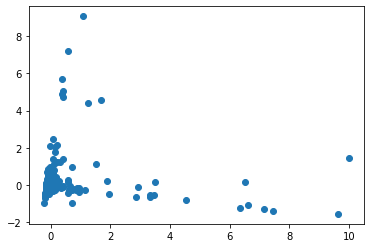

In [37]:
plt.scatter(*zip(*transformed))
plt.show()

In [27]:
i,j = 1000, 766
print(genres[i], genres[j], distances[i][j])
print(artist_genres[i], artist_genres[j], distances[i][j])

print(genre_artist_feature_vectors.shape)
type(genre_artist_feature_vectors)
genre_artist_feature_vectors[:5][:5]

korean indie rock classical guitar 1.0
['alternative r&b', 'indie jazz', 'indie r&b', 'indie soul', 'neo r&b', 'soul'] ['alternative dance', 'alternative rock', 'dance rock', 'dance-punk', 'electronic rock', 'electronica', 'indie pop', 'indie rock', 'indietronica', 'modern rock', 'new rave', 'rock'] 1.0
(1049, 1516)


array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False]])

In [ ]:
from dataclasses import dataclass, field
from typing import List, Type, Optional

@dataclass
class GenreNode:
    name: str
    split_name: List[str] = field(default_factory=list)
    parents: List[Type["GenreNode"]] = field(default_factory=list)
    children: List[Type["GenreNode"]] = field(default_factory=list)
    
    def __post_init__(self):
        self.split_name = self.name.replace("-", " ").split(" ")
    
    def __repr__(self):
        return f"{self.name}: ({len(self.children)}){[c.name for c in self.children]}" 
    
    def __len__(self):
        if not self.children: return 0
        return sum(len(child) or 1 for child in self.children)
    
    def is_supergenre_of(self, node):
        # second term is to prevent "dance pop" "pop dance" infinite loop
        return all(tok in node.split_name for tok in self.split_name) and len(self.split_name) < len(node.split_name)
    
    def remove_children_from_parents(self):       
        for parent in self.parents:
            for child in self.children:
                if child in parent.children:
                    parent.children.remove(child)
                if parent in child.parents:
                    child.parents.remove(parent)
            parent.remove_children_from_parents()
            
    def depth_from_parent(self, parent):
        if self == parent: return 0
        if not self.parents: return float("-inf")
        return max(map(lambda n: n.depth_from_parent(parent), self.parents)) + 1
            
    def print_tree(self, root=None, indent=0):
        print(indent*"\t" + f"{self.name} ({len(self)})")
        for child in sorted(self.children, key=lambda c: c.depth_from_parent(root), reverse=True):
            child.print_tree(root or self, indent+1)
            
    @staticmethod
    def tie_breaker(disputed_child, parents):
        # returns must suitable parent for child node. Returns None if unable to find best parent
        for i in range(len(disputed_child.split_name)):
            trimmed_child_name = " ".join(disputed_child.split_name[i:])
            matches = [parent for parent in parents
                       if " ".join(parent.split_name) == trimmed_child_name]  # Join split name instead of using name. Avoids issues with "-"
            if matches:
                if len(matches) == 1:
                    return matches[0]
                return None
            
            
def lexical_genre_hierarchy(genres): 
    def node_depth(node):
        if not node.parents: return 0
        return max(map(node_depth, node.parents)) + 1
    
    node_map = {genre: GenreNode(genre) for genre in genres}
    nodes = node_map.values()
    
    # first pass
    for node in nodes:
        subgenre_nodes = filter(node.is_supergenre_of, nodes)
        for subg_n in subgenre_nodes:
            if subg_n != node:
                node.children.append(subg_n)
                subg_n.parents.append(node)

    for leaf_node in filter(lambda n: n.parents and not n.children, nodes):
        leaf_node.remove_children_from_parents()
                 
    return node_map 


genre_series = pd.Series(flatten_series(genres).unique())
hierarchy = lexical_genre_hierarchy(genre_series)
ranked = sorted(hierarchy.values(), key=len, reverse=True)

for node in ranked[:3]:
    node.print_tree()                                              

for node in ranked[-3:]:
    node.print_tree()

In [ ]:
top_genres = [n.name for n in ranked[:10]]
merged.genres = merged.genres.apply(lambda gs: [g for g in gs if g in top_genres])

merged.month = df.endTime - pd.offsets.MonthBegin(0)
df.month = df.month.dt.round('d')

In [ ]:
# pd.plotting.scatter_matrix(adj_matrix)
top = adj_matrix.idxmax().head(10)
[(gs, adj_matrix[gs[0]][gs[1]]) for gs in top.items()]
stacked = adj_matrix.stack()
stacked[stacked > 0].sort_values(ascending=False).head(20)

In [ ]:
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, labels=adjacency_matrix.index, with_labels=True)
    plt.show()
    
# show_graph_with_labels(adj_matrix)
plt.figure(figsize=(25,17))
n = 15
nx.draw_networkx(nx.from_pandas_adjacency(adj_matrix[:n][:n]), node_size=800, node_color='lightblue', font_size=15)

In [ ]:
adj_list = genre_adj_list(artist_data.genres)
G = nx.Graph()
for _idx, genre, neighbors in adj_list.itertuples():
    G.add_edges_from([(genre, n) for n in set(neighbors)])
    

pos = nx.spring_layout(G)    
nx.draw_networkx_edge_labels(G, pos)
nx.draw(G, pos, edge_color='black')
plt.show()

In [ ]:
genre_count(merged).head(10)
merged.head(10)

weighted_genre_count(merged).head(10)

In [ ]:
def new_listens(df, granularity="month"):
    df = df.copy()
    df.sort_values(by="endTime", ascending=True)
    df.endTime = df.endTime - pd.offsets.MonthBegin(0)
    df.endTime = df.endTime.dt.round('d')
    
    known = set()
    df["new"] = 0
    
    # Doesn't account for different songs having same name. Solve using track ids
    for idx, track in df[["trackName"]].itertuples():
        if track not in known:
            known.add(track)
            df.at[idx, "new"] = 1
            
    return df.groupby("endTime")["new"].sum()


new_listens(df).plot(kind="bar")
plt.show()